"""
Generate data with specified changepoints
Compare ELBO fits for changepoint model with different
numbers of changepoints
"""

In [1]:
import os
import pickle
import scipy.stats as stats
import pymc3 as pm
import theano.tensor as tt
import numpy as np
import pylab as plt
from pymc3.variational.callbacks import CheckParametersConvergence
from theano.tensor.extra_ops import cumsum
import sys
sys.path.append('/media/bigdata/firing_space_plot/ephys_data')
from ephys_data import ephys_data
import visualize

In [9]:
nrn_num = 10
trial_num = 10
time_bins = 100
switch_components = 2
states = 3

In [10]:
true_tau = np.cumsum(np.random.random((trial_num,states)),axis=-1)
true_tau /= np.max(true_tau,axis=-1)[...,np.newaxis]
true_tau *= time_bins
true_tau = np.vectorize(np.int)(true_tau)

trial_tau = [7]
trial_lambda_selector = np.ones(trial_num)*len(trial_tau)
for val in trial_tau:
    trial_lambda_selector[:val] = trial_lambda_selector[:val]-1
trial_lambda_selector = np.vectorize(np.int)(trial_lambda_selector)

state_inds = np.concatenate([np.zeros((trial_num,1)),true_tau],axis=-1)
state_inds = np.vectorize(np.int)(state_inds)
true_tau = true_tau[:,:-1]

true_lambda = np.random.random((nrn_num,switch_components, states))

true_r = np.zeros((trial_num, nrn_num, time_bins))

for trial_ind in range(trial_num):
    for state_num in range(states):
        true_r[trial_ind,:,state_inds[trial_ind,state_num]:state_inds[trial_ind,state_num+1]] = \
                        true_lambda[:,trial_lambda_selector[trial_ind],state_num][:,np.newaxis]
        
data_array = np.random.random(true_r.shape) < true_r  

In [11]:
data_array.shape

(10, 10, 100)

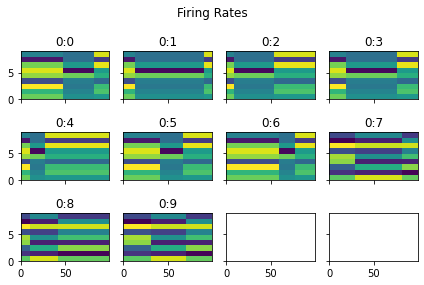

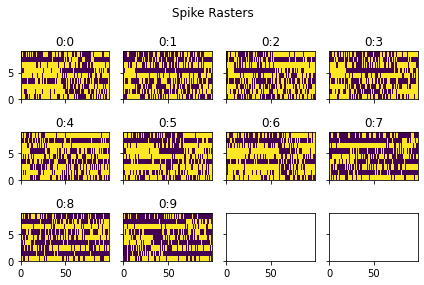

In [25]:
trial_count = 5
#trial_inds = np.random.choice(np.arange(trial_num),5)
trial_inds = np.arange(trial_num)
visualize.firing_overview(true_r[trial_inds], cmap = 'viridis');
plt.suptitle('Firing Rates')
plt.tight_layout()
fig = plt.gcf()
fig.savefig('/home/abuzarmahmood/Downloads/firing_rates.png', dpi = 300)

visualize.firing_overview(data_array[trial_inds], cmap='viridis');
plt.suptitle('Spike Rasters')
plt.tight_layout()
fig = plt.gcf()
fig.savefig('/home/abuzarmahmood/Downloads/spike_rasters.png', dpi = 300)

In [26]:
"""
Assuming only emissions change across trials
Changepoint distribution remains constant
"""

with pm.Model() as model:
    
    # Define Emissions
    
    # nrns
    nrn_lambda = pm.Exponential('nrn_lambda', 10, shape = (nrn_num))
    
    # nrns x switch_comps
    trial_lambda = pm.Exponential('trial_lambda', 
                                  nrn_lambda.dimshuffle(0,'x'), 
                                  shape = (nrn_num, switch_components))
    
    # nrns x switch_comps x states
    state_lambda = pm.Exponential('state_lambda',
                                 trial_lambda.dimshuffle(0,1,'x'),
                                 shape = (nrn_num, switch_components, states))
    
    # Define Changepoints
    # Assuming distribution of changepoints remains
    # the same across all trials

    a = pm.HalfCauchy('a_tau', 3., shape = states - 1)
    b = pm.HalfCauchy('b_tau', 3., shape = states - 1)
    
    even_switches = np.linspace(0,1,states+1)[1:-1]
    tau_latent = pm.Beta('tau_latent', a, b, 
                         testval = even_switches,
                         shape = (trial_num,states-1)).sort(axis=-1)    
    
    # Trials x Changepoints
    tau = pm.Deterministic('tau', time_bins * tau_latent)
    
    # Define trial switches
    # Will have same structure as regular changepoints
    
    even_trial_switches = np.linspace(0,1,switch_components+1)[1:-1]
    tau_trial_latent = pm.Beta('tau_trial_latent', 1, 1, 
                         testval = even_trial_switches,
                         shape = (switch_components-1)).sort(axis=-1)    
    
    # Trial_changepoints
    tau_trial = pm.Deterministic('tau_trial', trial_num * tau_trial_latent)
    
    trial_idx = np.arange(trial_num)
    trial_selector = tt.nnet.sigmoid(trial_idx[np.newaxis,:] - tau_trial.dimshuffle(0,'x'))
    
    trial_selector = tt.concatenate([np.ones((1,trial_num)),trial_selector],axis=0)
    inverse_trial_selector = 1 - trial_selector[1:,:]
    inverse_trial_selector = tt.concatenate([inverse_trial_selector, 
                                             np.ones((1,trial_num))],axis=0)

    # First, we can "select" sets of emissions depending on trial_changepoints 
    # switch_comps x trials
    trial_selector = np.multiply(trial_selector,inverse_trial_selector)
    
    # state_lambda: nrns x switch_comps x states
    
    # selected_trial_lambda : nrns x states x trials
    selected_trial_lambda = pm.Deterministic('selected_trial_lambda',
                            tt.sum(
                            # "nrns" x switch_comps x "states" x trials
                            trial_selector.dimshuffle('x',0,'x',1) * state_lambda.dimshuffle(0,1,2,'x'),
                            axis=1)
                                            )
    
    # Then, we can select state_emissions for every trial
    idx = np.arange(time_bins)
    
    # tau : Trials x Changepoints
    weight_stack = tt.nnet.sigmoid(idx[np.newaxis,:]-tau[:,:,np.newaxis])
    weight_stack = tt.concatenate([np.ones((trial_num,1,time_bins)),weight_stack],axis=1)
    inverse_stack = 1 - weight_stack[:,1:]
    inverse_stack = tt.concatenate([inverse_stack, np.ones((trial_num,1,time_bins))],axis=1)

    # Trials x states x Time
    weight_stack = np.multiply(weight_stack,inverse_stack)
    
    # Convert selected_trial_lambda : nrns x trials x states x "time"
    
    # nrns x trials x time
    lambda_ = tt.sum(selected_trial_lambda.dimshuffle(0,2,1,'x') * weight_stack.dimshuffle('x',0,1,2),
                     axis = 2)
    
    # Convert to : trials x nrns x time
    lambda_ = lambda_.dimshuffle(1,0,2)
    
    # Add observations
    observation = pm.Poisson("obs", lambda_, observed=data_array)

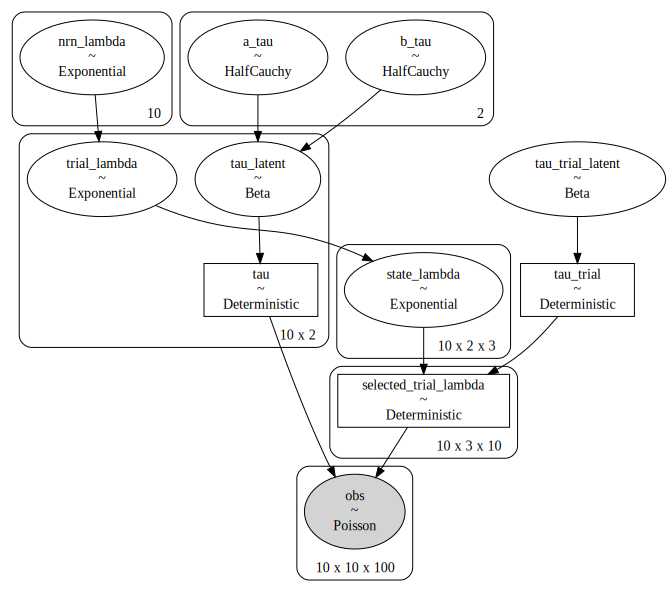

In [27]:
pm.model_to_graphviz(model)

In [28]:
fit = 20000
samples = 20000
with model:
    inference = pm.ADVI('full-rank')
    approx = pm.fit(n=fit, method=inference)
    trace = approx.sample(draws=samples)

Finished [100%]: Average Loss = 8,009.2


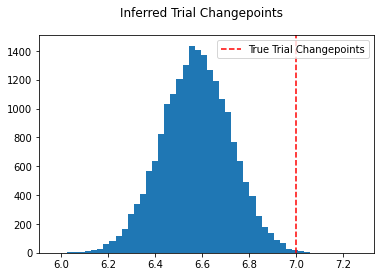

In [38]:
for dist in trace['tau_trial'].T:
    plt.hist(dist,bins = 50);
for num in trial_tau:
    plt.axvline(num, color = 'red', linestyle = '--',
               label = 'True Trial Changepoints')
plt.legend()
plt.suptitle('Inferred Trial Changepoints');
fig = plt.gcf()
fig.savefig('/home/abuzarmahmood/Downloads/trial_changepoint_comparison.png', dpi = 300)

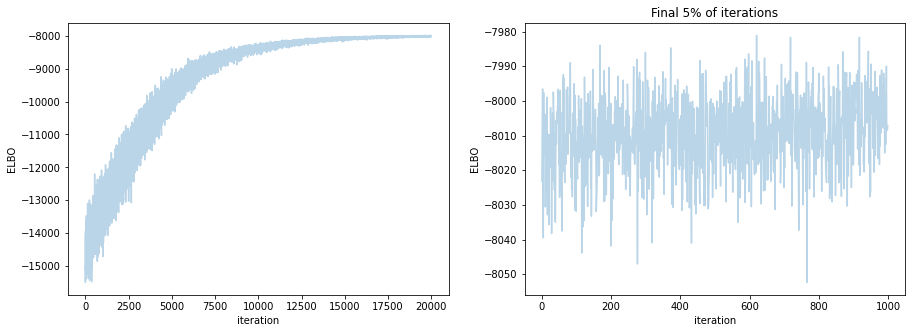

In [30]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(-approx.hist, alpha=.3)
ax[0].set_ylabel('ELBO')
ax[0].set_xlabel('iteration');

ind = int(fit - fit*0.05)
ax[1].plot(-approx.hist[ind:], alpha=.3)
ax[1].set_title('Final 5% of iterations')
ax[1].set_ylabel('ELBO')
ax[1].set_xlabel('iteration');

In [31]:
ppc = pm.sample_posterior_predictive(trace, samples = 200, model = model)

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


In [32]:
trial_count = 5
trial_inds = np.random.choice(np.arange(trial_num),5)

/media/bigdata/firing_space_plot/ephys_data/visualize.py:86: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  vmin = min_val[nrn], vmax = max_val[nrn])


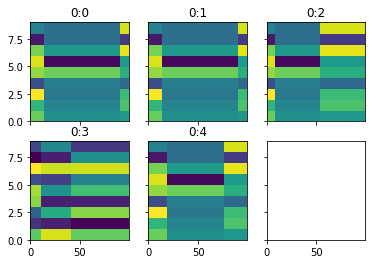

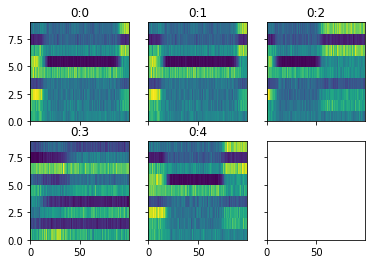

In [33]:
visualize.firing_overview(true_r[trial_inds],cmap='viridis');
visualize.firing_overview(np.mean(ppc['obs'],axis=0)[trial_inds],cmap='viridis');

In [34]:
mean_trial_lambda = np.mean(trace['selected_trial_lambda'],axis=0)
print(mean_trial_lambda.shape)

(10, 3, 10)


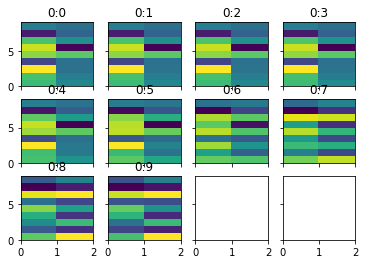

In [35]:
visualize.firing_overview(np.moveaxis(mean_trial_lambda,-1,0), cmap = 'viridis');

In [36]:
#min_val,max_val = min(true_r),max(true_r)
tau = trace['tau']
print(tau.shape)
mode_tau = stats.mode(np.vectorize(np.int)(tau),axis=0)[0][0]
print(mode_tau.shape)

(20000, 10, 2)
(10, 2)


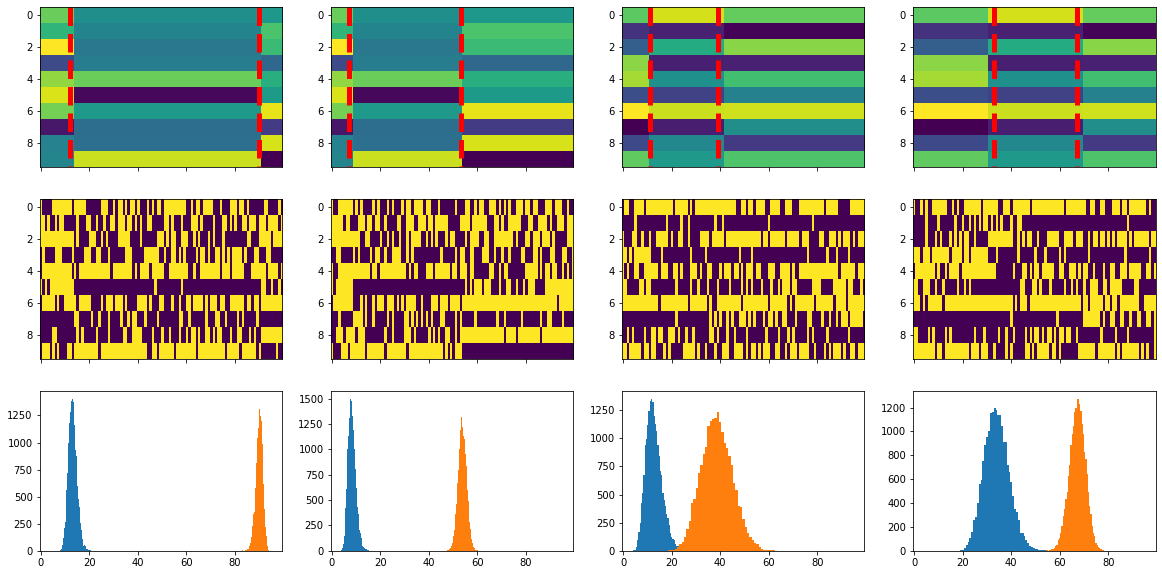

In [43]:
trial_inds = [1,2,8,9]
fig,ax = plt.subplots(3,len(trial_inds),sharex=True,figsize=(20,10))
for trial_num,this_trial_ind in enumerate(trial_inds):
    ax[0,trial_num].imshow(true_r[this_trial_ind],aspect='auto', interpolation='nearest')
    ax[1,trial_num].imshow(data_array[this_trial_ind],aspect='auto', interpolation='nearest')
    
    for tau_num, this_tau in enumerate(tau[:,this_trial_ind].T):
        ax[2,trial_num].hist(this_tau,bins=50)
        ax[0,trial_num].vlines(mode_tau[this_trial_ind,tau_num],-0.5,nrn_num-0.5,color='red',alpha=1,linewidth=5, linestyles='dashed')

fig = plt.gcf()
fig.savefig('/home/abuzarmahmood/Downloads/trial_changepoint_fit_examples.png', dpi = 300)